In [4]:
import os
import glob
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import SpatialDE as spde
import NaiveDE

# Define markers specifically for invasion
invasion_markers = ["MMP2", "MMP9", "S100A4", "CTNNB1"]

# Define directory for .h5ad files
directory = '/Users/adiallo/Desktop/Thesis/Data_Documents/All_Data/Visium_samples/Visium_Data/samples'
file_paths = glob.glob(os.path.join(directory, '*.h5ad'))

# Loop over each file path
for file_path in file_paths:
    # Read the adata file
    adata = sc.read_h5ad(file_path)

    # Extract spatial coordinates and gene expression data
    spatial_coords = adata.obsm['spatial']  # Assuming 'spatial' key contains coordinates
    expression_data = adata.to_df()  # Converts to DataFrame for easy handling

    # Combine coordinates with expression data
    data_df = pd.DataFrame(spatial_coords, columns=['x', 'y'])
    data_df = pd.concat([data_df, expression_data], axis=1)

    # Select genes based on minimum expression criteria
    min_expression = 0.1  # Example threshold
    min_cells = 10  # Minimum number of cells where gene must be expressed

    selected_genes = expression_data.columns[(expression_data > min_expression).sum() > min_cells]
    filtered_data_df = pd.concat([data_df[['x', 'y']], data_df[selected_genes]], axis=1)

    # Normalize and stabilize expression data
    counts = filtered_data_df[selected_genes]
    norm_expr = NaiveDE.stabilize(counts.T).T  # Stabilize expression counts

    # Prepare sample information for regression
    sample_info = data_df[['x', 'y']].copy()
    sample_info['total_counts'] = counts.sum(axis=1).values
    sample_info = sample_info[sample_info['total_counts'] > 0]  # Filter out zero-count rows
    norm_expr = norm_expr.loc[sample_info.index]  # Align indices

    # Directly assign spatial coordinates from adata.obsm['spatial']
    sample_info[['x', 'y']] = pd.DataFrame(adata.obsm['spatial'], index=adata.obs.index)

    # Debug checks
    print("Debug Checks:")
    print(f"Shape of sample_info: {sample_info.shape}")
    print(f"Shape of norm_expr: {norm_expr.shape}")
    print(f"Shape of X (spatial coordinates): {sample_info[['x', 'y']].shape}")
    print(f"NaNs in sample_info: \n{sample_info.isna().sum()}")

    # Regress out the effect of total counts
    resid_expr = NaiveDE.regress_out(sample_info, norm_expr.T, 'np.log(total_counts)').T

    # Check the residual expression matrix
    print(f"Shape of resid_expr after regression: {resid_expr.shape}")

    # Ensure only the genes used in the invasion score are included
    selected_genes_for_spatialde = [gene for gene in invasion_markers if gene in resid_expr.columns]

    if selected_genes_for_spatialde:
        # Run SpatialDE on the selected genes
        X = sample_info[['x', 'y']].values
        sample_resid_expr = resid_expr[selected_genes_for_spatialde]  # Only use the relevant genes
        results = spde.run(X, sample_resid_expr)

        # Filter significant results
        significant_results = results.query('qval < 0.05')
        print(f"Significant spatially variable genes from the score markers: {len(significant_results)}")

        # Create a dictionary of weights based on Fraction Spatial Variance (FSV)
        weights = significant_results.set_index('g')['FSV']

        # Initialize a DataFrame to store the weighted sum of expression values
        cells_marker_expression = pd.DataFrame(0, index=adata.obs.index, columns=['Weighted Invasion Score'])

        # Calculate the weighted, normalized invasion score
        for gene in invasion_markers:
            if gene in adata.var_names and gene in weights.index:
                gene_expression = adata[:, gene].X.toarray().ravel()
                normalized_expression = (gene_expression - np.mean(gene_expression)) / np.std(gene_expression)
                cells_marker_expression['Weighted Invasion Score'] += weights[gene] * normalized_expression
            elif gene not in adata.var_names:
                print(f"Gene {gene} not found in dataset. Skipping...")
            elif gene not in weights.index:
                print(f"Gene {gene} is not significant in SpatialDE analysis. Skipping...")

        # Plotting
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(
            adata.obsm['spatial'][:, 0], 
            adata.obsm['spatial'][:, 1], 
            c=cells_marker_expression['Weighted Invasion Score'],
            cmap='Purples',  # Color map for intensity
            alpha=0.6
        )
        plt.colorbar(scatter, label='Weighted Invasion Score')
        plt.xlabel('Spatial coordinate X')
        plt.ylabel('Spatial coordinate Y')
        plt.title(f'Spatial distribution of weighted invasion markers for {os.path.basename(file_path)}')

        # Save the plot
        plt.savefig(f"{os.path.splitext(file_path)[0]}_weighted_invasion_markers_intensity_plot.png", bbox_inches='tight')
        plt.close()
    else:
        print("No invasion markers found in the residual expression matrix.")


/opt/anaconda3/lib/python3.12/site-packages/NaiveDE/base.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  phi_hat, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, expression_matrix.mean(1), expression_matrix.var(1))


Debug Checks:
Shape of sample_info: (6971, 3)
Shape of norm_expr: (6971, 17779)
Shape of X (spatial coordinates): (6971, 2)
NaNs in sample_info: 
x               0
y               0
total_counts    0
dtype: int64
Shape of resid_expr after regression: (6971, 17779)


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/base.py:310: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  model_results = model_results[model_results.groupby(['g'])['max_ll'].transform(max) == model_results['max_ll']]
/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/util.py:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Significant spatially variable genes from the score markers: 4


/opt/anaconda3/lib/python3.12/site-packages/NaiveDE/base.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  phi_hat, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, expression_matrix.mean(1), expression_matrix.var(1))


Debug Checks:
Shape of sample_info: (6661, 3)
Shape of norm_expr: (6661, 17786)
Shape of X (spatial coordinates): (6661, 2)
NaNs in sample_info: 
x               0
y               0
total_counts    0
dtype: int64
Shape of resid_expr after regression: (6661, 17786)


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/base.py:310: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  model_results = model_results[model_results.groupby(['g'])['max_ll'].transform(max) == model_results['max_ll']]
/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/util.py:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Significant spatially variable genes from the score markers: 4


/opt/anaconda3/lib/python3.12/site-packages/NaiveDE/base.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  phi_hat, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, expression_matrix.mean(1), expression_matrix.var(1))


Debug Checks:
Shape of sample_info: (6987, 3)
Shape of norm_expr: (6987, 17796)
Shape of X (spatial coordinates): (6987, 2)
NaNs in sample_info: 
x               0
y               0
total_counts    0
dtype: int64
Shape of resid_expr after regression: (6987, 17796)


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/base.py:310: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  model_results = model_results[model_results.groupby(['g'])['max_ll'].transform(max) == model_results['max_ll']]
/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/util.py:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Significant spatially variable genes from the score markers: 4


/opt/anaconda3/lib/python3.12/site-packages/NaiveDE/base.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  phi_hat, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, expression_matrix.mean(1), expression_matrix.var(1))


Debug Checks:
Shape of sample_info: (6768, 3)
Shape of norm_expr: (6768, 17785)
Shape of X (spatial coordinates): (6768, 2)
NaNs in sample_info: 
x               0
y               0
total_counts    0
dtype: int64
Shape of resid_expr after regression: (6768, 17785)


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/base.py:310: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  model_results = model_results[model_results.groupby(['g'])['max_ll'].transform(max) == model_results['max_ll']]
/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/util.py:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Significant spatially variable genes from the score markers: 4


/opt/anaconda3/lib/python3.12/site-packages/NaiveDE/base.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  phi_hat, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, expression_matrix.mean(1), expression_matrix.var(1))


Debug Checks:
Shape of sample_info: (7485, 3)
Shape of norm_expr: (7485, 17791)
Shape of X (spatial coordinates): (7485, 2)
NaNs in sample_info: 
x               0
y               0
total_counts    0
dtype: int64
Shape of resid_expr after regression: (7485, 17791)


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/base.py:310: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  model_results = model_results[model_results.groupby(['g'])['max_ll'].transform(max) == model_results['max_ll']]
/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/util.py:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Significant spatially variable genes from the score markers: 4


/opt/anaconda3/lib/python3.12/site-packages/NaiveDE/base.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  phi_hat, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, expression_matrix.mean(1), expression_matrix.var(1))


Debug Checks:
Shape of sample_info: (6718, 3)
Shape of norm_expr: (6718, 17794)
Shape of X (spatial coordinates): (6718, 2)
NaNs in sample_info: 
x               0
y               0
total_counts    0
dtype: int64
Shape of resid_expr after regression: (6718, 17794)


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/base.py:310: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  model_results = model_results[model_results.groupby(['g'])['max_ll'].transform(max) == model_results['max_ll']]
/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/util.py:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Significant spatially variable genes from the score markers: 4


/opt/anaconda3/lib/python3.12/site-packages/NaiveDE/base.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  phi_hat, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, expression_matrix.mean(1), expression_matrix.var(1))
/opt/anaconda3/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


Debug Checks:
Shape of sample_info: (3411, 3)
Shape of norm_expr: (3411, 17793)
Shape of X (spatial coordinates): (3411, 2)
NaNs in sample_info: 
x               0
y               0
total_counts    0
dtype: int64
Shape of resid_expr after regression: (3411, 17793)


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/base.py:310: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  model_results = model_results[model_results.groupby(['g'])['max_ll'].transform(max) == model_results['max_ll']]
/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/util.py:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Significant spatially variable genes from the score markers: 1
Gene MMP2 is not significant in SpatialDE analysis. Skipping...
Gene S100A4 is not significant in SpatialDE analysis. Skipping...
Gene CTNNB1 is not significant in SpatialDE analysis. Skipping...


/opt/anaconda3/lib/python3.12/site-packages/NaiveDE/base.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  phi_hat, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, expression_matrix.mean(1), expression_matrix.var(1))


Debug Checks:
Shape of sample_info: (6414, 3)
Shape of norm_expr: (6414, 17794)
Shape of X (spatial coordinates): (6414, 2)
NaNs in sample_info: 
x               0
y               0
total_counts    0
dtype: int64
Shape of resid_expr after regression: (6414, 17794)


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/base.py:310: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  model_results = model_results[model_results.groupby(['g'])['max_ll'].transform(max) == model_results['max_ll']]
/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/util.py:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Significant spatially variable genes from the score markers: 4


/opt/anaconda3/lib/python3.12/site-packages/NaiveDE/base.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  phi_hat, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, expression_matrix.mean(1), expression_matrix.var(1))


Debug Checks:
Shape of sample_info: (6706, 3)
Shape of norm_expr: (6706, 17793)
Shape of X (spatial coordinates): (6706, 2)
NaNs in sample_info: 
x               0
y               0
total_counts    0
dtype: int64
Shape of resid_expr after regression: (6706, 17793)


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/base.py:310: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  model_results = model_results[model_results.groupby(['g'])['max_ll'].transform(max) == model_results['max_ll']]
/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/util.py:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Significant spatially variable genes from the score markers: 4


/opt/anaconda3/lib/python3.12/site-packages/NaiveDE/base.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  phi_hat, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, expression_matrix.mean(1), expression_matrix.var(1))


Debug Checks:
Shape of sample_info: (6989, 3)
Shape of norm_expr: (6989, 17795)
Shape of X (spatial coordinates): (6989, 2)
NaNs in sample_info: 
x               0
y               0
total_counts    0
dtype: int64
Shape of resid_expr after regression: (6989, 17795)


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/base.py:310: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  model_results = model_results[model_results.groupby(['g'])['max_ll'].transform(max) == model_results['max_ll']]
/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/util.py:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Significant spatially variable genes from the score markers: 4


/opt/anaconda3/lib/python3.12/site-packages/NaiveDE/base.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  phi_hat, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, expression_matrix.mean(1), expression_matrix.var(1))


Debug Checks:
Shape of sample_info: (6492, 3)
Shape of norm_expr: (6492, 17793)
Shape of X (spatial coordinates): (6492, 2)
NaNs in sample_info: 
x               0
y               0
total_counts    0
dtype: int64
Shape of resid_expr after regression: (6492, 17793)


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/base.py:310: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  model_results = model_results[model_results.groupby(['g'])['max_ll'].transform(max) == model_results['max_ll']]
/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/util.py:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Significant spatially variable genes from the score markers: 4


/opt/anaconda3/lib/python3.12/site-packages/NaiveDE/base.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  phi_hat, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, expression_matrix.mean(1), expression_matrix.var(1))


Debug Checks:
Shape of sample_info: (6826, 3)
Shape of norm_expr: (6826, 17753)
Shape of X (spatial coordinates): (6826, 2)
NaNs in sample_info: 
x               0
y               0
total_counts    0
dtype: int64
Shape of resid_expr after regression: (6826, 17753)


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/base.py:310: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  model_results = model_results[model_results.groupby(['g'])['max_ll'].transform(max) == model_results['max_ll']]
/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/util.py:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Significant spatially variable genes from the score markers: 4


/opt/anaconda3/lib/python3.12/site-packages/NaiveDE/base.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  phi_hat, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, expression_matrix.mean(1), expression_matrix.var(1))


Debug Checks:
Shape of sample_info: (7274, 3)
Shape of norm_expr: (7274, 17787)
Shape of X (spatial coordinates): (7274, 2)
NaNs in sample_info: 
x               0
y               0
total_counts    0
dtype: int64
Shape of resid_expr after regression: (7274, 17787)


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/base.py:310: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  model_results = model_results[model_results.groupby(['g'])['max_ll'].transform(max) == model_results['max_ll']]
/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/util.py:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Significant spatially variable genes from the score markers: 4


/opt/anaconda3/lib/python3.12/site-packages/NaiveDE/base.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  phi_hat, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, expression_matrix.mean(1), expression_matrix.var(1))


Debug Checks:
Shape of sample_info: (5910, 3)
Shape of norm_expr: (5910, 17789)
Shape of X (spatial coordinates): (5910, 2)
NaNs in sample_info: 
x               0
y               0
total_counts    0
dtype: int64
Shape of resid_expr after regression: (5910, 17789)


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/base.py:310: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  model_results = model_results[model_results.groupby(['g'])['max_ll'].transform(max) == model_results['max_ll']]
/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/util.py:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Significant spatially variable genes from the score markers: 4


/opt/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/lib/python3.12/site-packages/NaiveDE/base.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  phi_hat, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, expression_matrix.mean(1), expression_matrix.var(1))


Debug Checks:
Shape of sample_info: (7480, 3)
Shape of norm_expr: (7480, 18058)
Shape of X (spatial coordinates): (7480, 2)
NaNs in sample_info: 
x               0
y               0
total_counts    0
dtype: int64
Shape of resid_expr after regression: (7480, 18058)


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/base.py:310: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  model_results = model_results[model_results.groupby(['g'])['max_ll'].transform(max) == model_results['max_ll']]
/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/util.py:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Significant spatially variable genes from the score markers: 4


/opt/anaconda3/lib/python3.12/site-packages/NaiveDE/base.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  phi_hat, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, expression_matrix.mean(1), expression_matrix.var(1))


Debug Checks:
Shape of sample_info: (6658, 3)
Shape of norm_expr: (6658, 17795)
Shape of X (spatial coordinates): (6658, 2)
NaNs in sample_info: 
x               0
y               0
total_counts    0
dtype: int64
Shape of resid_expr after regression: (6658, 17795)


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/base.py:310: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  model_results = model_results[model_results.groupby(['g'])['max_ll'].transform(max) == model_results['max_ll']]
/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/util.py:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Significant spatially variable genes from the score markers: 4


/opt/anaconda3/lib/python3.12/site-packages/NaiveDE/base.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  phi_hat, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, expression_matrix.mean(1), expression_matrix.var(1))


Debug Checks:
Shape of sample_info: (6651, 3)
Shape of norm_expr: (6651, 17795)
Shape of X (spatial coordinates): (6651, 2)
NaNs in sample_info: 
x               0
y               0
total_counts    0
dtype: int64
Shape of resid_expr after regression: (6651, 17795)


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/base.py:310: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  model_results = model_results[model_results.groupby(['g'])['max_ll'].transform(max) == model_results['max_ll']]
/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/util.py:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Significant spatially variable genes from the score markers: 4


/opt/anaconda3/lib/python3.12/site-packages/NaiveDE/base.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  phi_hat, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, expression_matrix.mean(1), expression_matrix.var(1))


Debug Checks:
Shape of sample_info: (5903, 3)
Shape of norm_expr: (5903, 17789)
Shape of X (spatial coordinates): (5903, 2)
NaNs in sample_info: 
x               0
y               0
total_counts    0
dtype: int64
Shape of resid_expr after regression: (5903, 17789)


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/base.py:310: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  model_results = model_results[model_results.groupby(['g'])['max_ll'].transform(max) == model_results['max_ll']]
/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/util.py:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Significant spatially variable genes from the score markers: 4


/opt/anaconda3/lib/python3.12/site-packages/NaiveDE/base.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  phi_hat, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, expression_matrix.mean(1), expression_matrix.var(1))


Debug Checks:
Shape of sample_info: (6502, 3)
Shape of norm_expr: (6502, 17785)
Shape of X (spatial coordinates): (6502, 2)
NaNs in sample_info: 
x               0
y               0
total_counts    0
dtype: int64
Shape of resid_expr after regression: (6502, 17785)


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/base.py:310: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  model_results = model_results[model_results.groupby(['g'])['max_ll'].transform(max) == model_results['max_ll']]
/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/util.py:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Significant spatially variable genes from the score markers: 4


/opt/anaconda3/lib/python3.12/site-packages/NaiveDE/base.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  phi_hat, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, expression_matrix.mean(1), expression_matrix.var(1))


Debug Checks:
Shape of sample_info: (7353, 3)
Shape of norm_expr: (7353, 17789)
Shape of X (spatial coordinates): (7353, 2)
NaNs in sample_info: 
x               0
y               0
total_counts    0
dtype: int64
Shape of resid_expr after regression: (7353, 17789)


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/base.py:310: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  model_results = model_results[model_results.groupby(['g'])['max_ll'].transform(max) == model_results['max_ll']]
/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/util.py:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Significant spatially variable genes from the score markers: 4


/opt/anaconda3/lib/python3.12/site-packages/NaiveDE/base.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  phi_hat, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, expression_matrix.mean(1), expression_matrix.var(1))


Debug Checks:
Shape of sample_info: (6319, 3)
Shape of norm_expr: (6319, 17794)
Shape of X (spatial coordinates): (6319, 2)
NaNs in sample_info: 
x               0
y               0
total_counts    0
dtype: int64
Shape of resid_expr after regression: (6319, 17794)


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/base.py:310: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  model_results = model_results[model_results.groupby(['g'])['max_ll'].transform(max) == model_results['max_ll']]
/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/util.py:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Significant spatially variable genes from the score markers: 4


/opt/anaconda3/lib/python3.12/site-packages/NaiveDE/base.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  phi_hat, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, expression_matrix.mean(1), expression_matrix.var(1))


Debug Checks:
Shape of sample_info: (5571, 3)
Shape of norm_expr: (5571, 17794)
Shape of X (spatial coordinates): (5571, 2)
NaNs in sample_info: 
x               0
y               0
total_counts    0
dtype: int64
Shape of resid_expr after regression: (5571, 17794)


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/base.py:310: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  model_results = model_results[model_results.groupby(['g'])['max_ll'].transform(max) == model_results['max_ll']]
/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/util.py:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Significant spatially variable genes from the score markers: 4


/opt/anaconda3/lib/python3.12/site-packages/NaiveDE/base.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  phi_hat, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, expression_matrix.mean(1), expression_matrix.var(1))


Debug Checks:
Shape of sample_info: (7194, 3)
Shape of norm_expr: (7194, 17794)
Shape of X (spatial coordinates): (7194, 2)
NaNs in sample_info: 
x               0
y               0
total_counts    0
dtype: int64
Shape of resid_expr after regression: (7194, 17794)


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/base.py:310: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  model_results = model_results[model_results.groupby(['g'])['max_ll'].transform(max) == model_results['max_ll']]
/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/util.py:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Significant spatially variable genes from the score markers: 4


/opt/anaconda3/lib/python3.12/site-packages/NaiveDE/base.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  phi_hat, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, expression_matrix.mean(1), expression_matrix.var(1))


Debug Checks:
Shape of sample_info: (7173, 3)
Shape of norm_expr: (7173, 17795)
Shape of X (spatial coordinates): (7173, 2)
NaNs in sample_info: 
x               0
y               0
total_counts    0
dtype: int64
Shape of resid_expr after regression: (7173, 17795)


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/base.py:310: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  model_results = model_results[model_results.groupby(['g'])['max_ll'].transform(max) == model_results['max_ll']]
/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/util.py:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Significant spatially variable genes from the score markers: 4


/opt/anaconda3/lib/python3.12/site-packages/NaiveDE/base.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  phi_hat, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, expression_matrix.mean(1), expression_matrix.var(1))


Debug Checks:
Shape of sample_info: (7057, 3)
Shape of norm_expr: (7057, 17789)
Shape of X (spatial coordinates): (7057, 2)
NaNs in sample_info: 
x               0
y               0
total_counts    0
dtype: int64
Shape of resid_expr after regression: (7057, 17789)


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/base.py:310: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  model_results = model_results[model_results.groupby(['g'])['max_ll'].transform(max) == model_results['max_ll']]
/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/util.py:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Significant spatially variable genes from the score markers: 4


/opt/anaconda3/lib/python3.12/site-packages/NaiveDE/base.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  phi_hat, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, expression_matrix.mean(1), expression_matrix.var(1))


Debug Checks:
Shape of sample_info: (7010, 3)
Shape of norm_expr: (7010, 17787)
Shape of X (spatial coordinates): (7010, 2)
NaNs in sample_info: 
x               0
y               0
total_counts    0
dtype: int64
Shape of resid_expr after regression: (7010, 17787)


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/base.py:310: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  model_results = model_results[model_results.groupby(['g'])['max_ll'].transform(max) == model_results['max_ll']]
/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/util.py:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Significant spatially variable genes from the score markers: 4


/opt/anaconda3/lib/python3.12/site-packages/NaiveDE/base.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  phi_hat, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, expression_matrix.mean(1), expression_matrix.var(1))


Debug Checks:
Shape of sample_info: (6342, 3)
Shape of norm_expr: (6342, 17785)
Shape of X (spatial coordinates): (6342, 2)
NaNs in sample_info: 
x               0
y               0
total_counts    0
dtype: int64
Shape of resid_expr after regression: (6342, 17785)


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/base.py:310: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  model_results = model_results[model_results.groupby(['g'])['max_ll'].transform(max) == model_results['max_ll']]
/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/util.py:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Significant spatially variable genes from the score markers: 4


/opt/anaconda3/lib/python3.12/site-packages/NaiveDE/base.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  phi_hat, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, expression_matrix.mean(1), expression_matrix.var(1))


Debug Checks:
Shape of sample_info: (6847, 3)
Shape of norm_expr: (6847, 17783)
Shape of X (spatial coordinates): (6847, 2)
NaNs in sample_info: 
x               0
y               0
total_counts    0
dtype: int64
Shape of resid_expr after regression: (6847, 17783)


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/base.py:310: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  model_results = model_results[model_results.groupby(['g'])['max_ll'].transform(max) == model_results['max_ll']]
/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/util.py:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Significant spatially variable genes from the score markers: 4


/opt/anaconda3/lib/python3.12/site-packages/NaiveDE/base.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  phi_hat, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, expression_matrix.mean(1), expression_matrix.var(1))


Debug Checks:
Shape of sample_info: (6297, 3)
Shape of norm_expr: (6297, 17784)
Shape of X (spatial coordinates): (6297, 2)
NaNs in sample_info: 
x               0
y               0
total_counts    0
dtype: int64
Shape of resid_expr after regression: (6297, 17784)


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/base.py:310: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  model_results = model_results[model_results.groupby(['g'])['max_ll'].transform(max) == model_results['max_ll']]
/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/util.py:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Significant spatially variable genes from the score markers: 4


/opt/anaconda3/lib/python3.12/site-packages/NaiveDE/base.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  phi_hat, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, expression_matrix.mean(1), expression_matrix.var(1))


Debug Checks:
Shape of sample_info: (6526, 3)
Shape of norm_expr: (6526, 17789)
Shape of X (spatial coordinates): (6526, 2)
NaNs in sample_info: 
x               0
y               0
total_counts    0
dtype: int64
Shape of resid_expr after regression: (6526, 17789)


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/base.py:310: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  model_results = model_results[model_results.groupby(['g'])['max_ll'].transform(max) == model_results['max_ll']]
/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/util.py:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Significant spatially variable genes from the score markers: 4


/opt/anaconda3/lib/python3.12/site-packages/NaiveDE/base.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  phi_hat, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, expression_matrix.mean(1), expression_matrix.var(1))


Debug Checks:
Shape of sample_info: (6855, 3)
Shape of norm_expr: (6855, 17786)
Shape of X (spatial coordinates): (6855, 2)
NaNs in sample_info: 
x               0
y               0
total_counts    0
dtype: int64
Shape of resid_expr after regression: (6855, 17786)


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/base.py:310: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  model_results = model_results[model_results.groupby(['g'])['max_ll'].transform(max) == model_results['max_ll']]
/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/util.py:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Significant spatially variable genes from the score markers: 4


/opt/anaconda3/lib/python3.12/site-packages/NaiveDE/base.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  phi_hat, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, expression_matrix.mean(1), expression_matrix.var(1))


Debug Checks:
Shape of sample_info: (8238, 3)
Shape of norm_expr: (8238, 17794)
Shape of X (spatial coordinates): (8238, 2)
NaNs in sample_info: 
x               0
y               0
total_counts    0
dtype: int64
Shape of resid_expr after regression: (8238, 17794)


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/base.py:310: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  model_results = model_results[model_results.groupby(['g'])['max_ll'].transform(max) == model_results['max_ll']]
/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/util.py:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Significant spatially variable genes from the score markers: 4


/opt/anaconda3/lib/python3.12/site-packages/NaiveDE/base.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  phi_hat, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, expression_matrix.mean(1), expression_matrix.var(1))


Debug Checks:
Shape of sample_info: (6532, 3)
Shape of norm_expr: (6532, 17795)
Shape of X (spatial coordinates): (6532, 2)
NaNs in sample_info: 
x               0
y               0
total_counts    0
dtype: int64
Shape of resid_expr after regression: (6532, 17795)


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/base.py:310: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  model_results = model_results[model_results.groupby(['g'])['max_ll'].transform(max) == model_results['max_ll']]
/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/util.py:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Significant spatially variable genes from the score markers: 4


/opt/anaconda3/lib/python3.12/site-packages/NaiveDE/base.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  phi_hat, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, expression_matrix.mean(1), expression_matrix.var(1))


Debug Checks:
Shape of sample_info: (6138, 3)
Shape of norm_expr: (6138, 17795)
Shape of X (spatial coordinates): (6138, 2)
NaNs in sample_info: 
x               0
y               0
total_counts    0
dtype: int64
Shape of resid_expr after regression: (6138, 17795)


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/base.py:310: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  model_results = model_results[model_results.groupby(['g'])['max_ll'].transform(max) == model_results['max_ll']]
/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/util.py:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Significant spatially variable genes from the score markers: 4


/opt/anaconda3/lib/python3.12/site-packages/NaiveDE/base.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  phi_hat, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, expression_matrix.mean(1), expression_matrix.var(1))


Debug Checks:
Shape of sample_info: (7191, 3)
Shape of norm_expr: (7191, 17795)
Shape of X (spatial coordinates): (7191, 2)
NaNs in sample_info: 
x               0
y               0
total_counts    0
dtype: int64
Shape of resid_expr after regression: (7191, 17795)


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/base.py:310: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  model_results = model_results[model_results.groupby(['g'])['max_ll'].transform(max) == model_results['max_ll']]
/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/util.py:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Significant spatially variable genes from the score markers: 4


/opt/anaconda3/lib/python3.12/site-packages/NaiveDE/base.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  phi_hat, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, expression_matrix.mean(1), expression_matrix.var(1))


Debug Checks:
Shape of sample_info: (6873, 3)
Shape of norm_expr: (6873, 17795)
Shape of X (spatial coordinates): (6873, 2)
NaNs in sample_info: 
x               0
y               0
total_counts    0
dtype: int64
Shape of resid_expr after regression: (6873, 17795)


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/base.py:310: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  model_results = model_results[model_results.groupby(['g'])['max_ll'].transform(max) == model_results['max_ll']]
/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/util.py:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Significant spatially variable genes from the score markers: 4


/opt/anaconda3/lib/python3.12/site-packages/NaiveDE/base.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  phi_hat, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, expression_matrix.mean(1), expression_matrix.var(1))


Debug Checks:
Shape of sample_info: (6476, 3)
Shape of norm_expr: (6476, 17793)
Shape of X (spatial coordinates): (6476, 2)
NaNs in sample_info: 
x               0
y               0
total_counts    0
dtype: int64
Shape of resid_expr after regression: (6476, 17793)


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/base.py:310: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  model_results = model_results[model_results.groupby(['g'])['max_ll'].transform(max) == model_results['max_ll']]
/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/util.py:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Significant spatially variable genes from the score markers: 4


/opt/anaconda3/lib/python3.12/site-packages/NaiveDE/base.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  phi_hat, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, expression_matrix.mean(1), expression_matrix.var(1))


Debug Checks:
Shape of sample_info: (7217, 3)
Shape of norm_expr: (7217, 17791)
Shape of X (spatial coordinates): (7217, 2)
NaNs in sample_info: 
x               0
y               0
total_counts    0
dtype: int64
Shape of resid_expr after regression: (7217, 17791)


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/base.py:310: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  model_results = model_results[model_results.groupby(['g'])['max_ll'].transform(max) == model_results['max_ll']]
/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/util.py:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Significant spatially variable genes from the score markers: 4


/opt/anaconda3/lib/python3.12/site-packages/NaiveDE/base.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  phi_hat, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, expression_matrix.mean(1), expression_matrix.var(1))


Debug Checks:
Shape of sample_info: (7088, 3)
Shape of norm_expr: (7088, 17787)
Shape of X (spatial coordinates): (7088, 2)
NaNs in sample_info: 
x               0
y               0
total_counts    0
dtype: int64
Shape of resid_expr after regression: (7088, 17787)


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/base.py:310: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  model_results = model_results[model_results.groupby(['g'])['max_ll'].transform(max) == model_results['max_ll']]
/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/util.py:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Significant spatially variable genes from the score markers: 4


/opt/anaconda3/lib/python3.12/site-packages/NaiveDE/base.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  phi_hat, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, expression_matrix.mean(1), expression_matrix.var(1))


Debug Checks:
Shape of sample_info: (7046, 3)
Shape of norm_expr: (7046, 17783)
Shape of X (spatial coordinates): (7046, 2)
NaNs in sample_info: 
x               0
y               0
total_counts    0
dtype: int64
Shape of resid_expr after regression: (7046, 17783)


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/base.py:310: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  model_results = model_results[model_results.groupby(['g'])['max_ll'].transform(max) == model_results['max_ll']]
/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/util.py:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Significant spatially variable genes from the score markers: 4


/opt/anaconda3/lib/python3.12/site-packages/NaiveDE/base.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  phi_hat, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, expression_matrix.mean(1), expression_matrix.var(1))


Debug Checks:
Shape of sample_info: (6142, 3)
Shape of norm_expr: (6142, 17780)
Shape of X (spatial coordinates): (6142, 2)
NaNs in sample_info: 
x               0
y               0
total_counts    0
dtype: int64
Shape of resid_expr after regression: (6142, 17780)


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/base.py:310: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  model_results = model_results[model_results.groupby(['g'])['max_ll'].transform(max) == model_results['max_ll']]
/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/util.py:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Significant spatially variable genes from the score markers: 4


/var/folders/pt/fnxwl25d6cj484ywz_9by07w0000gq/T/ipykernel_3599/3644588275.py:5: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.axhline(0.05, c='black', lw=1, ls='--')


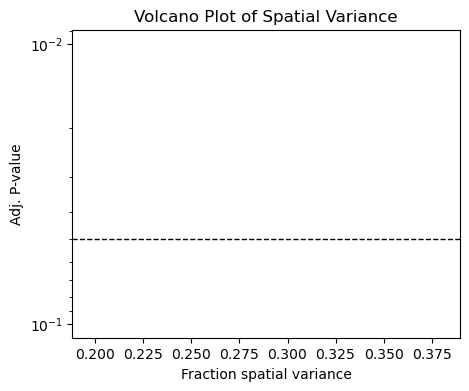